# LiH - Confronti tra metodi UCC ~ 23 min

In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# Array distanze e energie
arr_distance = np.arange(0.845, 4.85, 0.25) # 14 punti 
arr_ground_energy = {}
arr_intermediate  = {}
arr_results = {}
arr_methods = []
times = {}

## 0 - LiH

In [53]:
from pyscf import gto, scf, fci
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers  import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicStructureProblem

In [54]:
def generate_LiH_mol (distance: float = 0.1, basis: str = 'sto3g'):
    LiH = "Li .0 .0 .0; H .0 .0 " + str(distance)
    
    mol = gto.M(
        atom=LiH,
        charge=0,
        spin=0,
        basis=basis,
        symmetry=False,
        verbose=0
    )
    
    driver = PySCFDriver(
        atom=LiH,
        basis=basis, 
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM
    )    
    
    problem = driver.run()
    
    return mol, problem
    
    

### 0.1 - HF e FCI

In [55]:
arr_ground_energy['HF'] = []

arr_ground_energy['FCI'] = []
arr_results['FCI'] = []
arr_methods.append('FCI')

def compute_fci_energy (mol):
    # per ciascuna molecola calcolo il campo medio con restricted HF 
    cm  = scf.RHF(mol) # campo medio
    e_HF = cm.kernel() # questo va runnato a prescindere
    
    n_frozen_orbitals = 1
    # per ciascuna molecola calcolo FCI
    fci_calc = fci.FCI(cm) # <- nei metodi correlati passiamo come argomento un conto di campo medio, HF
    e_FCI = fci_calc.kernel(frozen=n_frozen_orbitals)[0]

    return e_HF, e_FCI

### 0.2 - EfficientSU2

In [56]:
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.second_q.mappers import QubitMapper, JordanWignerMapper, ParityMapper

arr_ground_energy['EfficientSU2'] = []
arr_intermediate ['EfficientSU2'] = []
arr_results['EfficientSU2'] = []
arr_methods.append('EfficientSU2')
ini_efficient = None
times['EfficientSU2'] = []

def generate_efficient_ansatz (problem: ElectronicStructureProblem, mapper: JordanWignerMapper()):
    # numero di qubits dell'operatore
    second_q_op = problem.second_q_ops()[0]
    qubit_op = mapper.map(second_q_op)
    num_qubits = qubit_op.num_qubits
    
    efficient = EfficientSU2(num_qubits, entanglement='reverse_linear') 
    
    ini_efficient = [0. for _ in range(efficient.num_parameters)]
    bounds = [[-np.pi,np.pi] for _ in range(efficient.num_parameters)]
    efficient._bounds = bounds
    
    return efficient

## 1- UCC Methods

In [57]:
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC, UCCSD, PUCCD

### 1.1 - UCCS

In [58]:
arr_ground_energy['UCCS'] = []
arr_intermediate ['UCCS'] = []
arr_results['UCCS'] = []
arr_methods.append('UCCS')
ini_uccs = None
times['UCCS'] = []

def generate_uccs_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    uccs = UCC(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        excitations='s',
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_uccs = [0. for _ in range(uccs.num_parameters)]
    bounds = [[-np.pi,np.pi] for _ in range(uccs.num_parameters)]
    uccs._bounds = bounds
    
    return uccs

### 1.2 - UCCD 

In [59]:
arr_ground_energy['UCCD'] = []
arr_intermediate ['UCCD'] = []
arr_results['UCCD'] = []
arr_methods.append('UCCD')
ini_uccd = None
times['UCCD'] = []

def generate_uccd_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    uccd = UCC(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        excitations='d',
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_uccd = [0. for _ in range(uccd.num_parameters)]
    bounds = [[-np.pi,np.pi] for _ in range(uccd.num_parameters)]
    uccd._bounds = bounds
    
    return uccd

### 1.3 - UCCSD

In [60]:
arr_ground_energy['UCCSD'] = []
arr_intermediate ['UCCSD'] = []
arr_results['UCCSD'] = []
arr_methods.append('UCCSD')
ini_uccsd = None
times['UCCSD'] = []

def generate_uccsd_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    uccsd = UCCSD(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        #excitations='sd',
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_uccsd = [0. for _ in range(uccsd.num_parameters)]
    bounds = [[-np.pi,np.pi] for _ in range(uccsd.num_parameters)]
    uccsd._bounds = bounds
    
    return uccsd

### 1.4 - pUCCD

In [61]:
arr_ground_energy['pUCCD'] = []
arr_intermediate ['pUCCD'] = []
arr_results['pUCCD'] = []
arr_methods.append('pUCCD')
ini_puccd = None
times['pUCCD'] = []

def generate_puccd_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    
    puccd = PUCCD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_puccd = [0. for _ in range(puccd.num_parameters)]
    bounds = [[-np.pi,np.pi] for _ in range(puccd.num_parameters)]
    puccd._bounds = bounds
    
    return puccd

### Aiuti

In [62]:
ini_efficient = [
    -2.186739E-03, 3.138488E+00, 3.140196E+00, -9.481660E-05, 7.995198E+00,
    -2.737561E-03, 1.952014E-03, -3.607928E-02, 1.565145E+00, 4.009320E+00,
    1.334737E+01, 2.316470E+01, 7.956625E+00, 2.335445E+01, 7.632023E+00,
    1.464730E+01, 1.392841E+01, 6.233383E+00, -1.639559E+00, 4.728732E+00,
    5.626069E+00, 1.570908E+00, 1.574628E+00, -2.038900E-03, 1.554055E+00,
    -1.185306E-01, 1.550712E+00, 7.755393E-02, 2.193111E+00, -1.520640E+00,
    3.610589E+00, -1.881937E-04, -9.643360E-05, 5.569587E+00, -1.542373E-02,
    2.712998E+00, 2.644022E-03, 6.147733E+00, 1.578264E+00, -2.540044E-01,
    -1.568423E+00, 1.569479E+00, -1.569374E+00, 1.569275E+00, 6.495774E-01,
    -6.454658E-01, -1.570689E+00, -1.572805E+00, -1.527162E+00, 1.544493E+00,
    -1.559903E+00, 3.485361E+00, -1.790248E+00, 1.146081E-01, -2.484256E+00,
    4.004573E-02, 3.271965E+00, -3.303461E+00, -1.564120E+00, -1.615251E+00,
    1.570735E+00, -3.144464E+00, 4.204878E-04, -3.139445E+00, -1.565164E+00,
    3.126849E-02, 1.487691E+00, 2.545967E-02, 1.499377E+00, 1.559064E+00,
    2.094624E+00, 3.999730E+00, 1.237494E+01, 1.910835E+01, 3.664773E+00,
    3.811231E+00, -3.391413E+00, 2.138140E+00, 6.476299E+00, -1.814226E+00,
]

In [63]:
ini_uccs = [3.123821E+00,   3.142885E+00,  -1.418939E-03,  -3.140251E+00,   3.152435E+00,
           -3.138668E+00,   3.140575E+00,  -1.366617E-03]

In [64]:
ini_uccd = [0.02265631, -0.007787484, 3.139672, 3.097497, -0.001903558,
 0.03151177, -0.00186963, 3.136378, -3.143199, 3.142751,
 3.179203, 3.140637, 0.04329709, -3.144375, 3.143464,
 -0.09673738]

In [65]:
ini_uccsd = [-0.01877147, -0.04941062, -0.1251208, 1.528925, -1.504983,
            3.815334, 3.23566, 1.742724, -2.810608, 2.581604,
            2.654631, 2.963959, -1.659677, -1.703403, -1.839795,
            -2.28938, 1.467188, 3.148665, -0.3665278, 0.05325239,
            4.551188, -0.04134156, 3.146543, -0.1515372]

In [66]:
ini_puccd = [3.749428E-03,   3.645277E-02,   3.987719E-02,   3.032522E+00]

## 2 - Solver

In [67]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, SLSQP, NFT, L_BFGS_B
from qiskit.primitives import Estimator 
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

In [68]:
# vettori che andranno a raccogliere i risultati delle varie iterazioni dell'algoritmo
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [69]:
def solve_problem (problem: ElectronicStructureProblem, 
                   ansatz: UCC, 
                   intermediate: list = None,
                   ini: np.ndarray = None, 
                   opt=SLSQP(maxiter=1000), 
                   mapper: QubitMapper = JordanWignerMapper()):
    
    counts = []
    values = []
    std_val = [] 

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        std_val.append(std)
        
    vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)
    
    if ini is None:
        ini = [0.0] * ansatz.num_parameters
    else:
        vqe_solver.initial_point = ini
    
    calc = GroundStateEigensolver(mapper, vqe_solver)

    res = calc.solve(problem)
    
    # conservo i valori intermedi
    intermediate.append([counts, values, std_val])    
    
    return res

In [70]:
# per shiftare i values intermediate
def shift_intermediate (intermediate, shift):
    return [val+shift for val in intermediate]

## 3 - Ex

In [71]:
# Parametri per la risoluzione
# SLSQP(maxiter=10) 22 min ma uccd ancora sballato in d<2.25
# SLSQP() 60 min ma uccsd ancora sballato
opt    = COBYLA(maxiter=5000, tol=0.01, rhobeg=3, disp=True) # 
mapper = JordanWignerMapper()
basis  = 'sto3g'

# Per conservare i tempi di esecuzione
from time import time

In [72]:
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
freezer = FreezeCoreTransformer()

In [ ]:
for distance in arr_distance:
    print('------------------------', distance, '------------------------')
    mol, problem = generate_LiH_mol(distance=distance, basis=basis)
    
    problem = freezer.transform(problem)
    
    # 0 - HF & FCI
    e_HF, e_FCI = compute_fci_energy(mol=mol)
    arr_ground_energy['HF'].append(e_HF)
    arr_ground_energy['FCI'].append(e_FCI)
    
    print('HF:  ', e_HF)
    print('FCI: ', e_FCI)
    
    # 0.1 - EfficientSU2
    start_time = time()
    efficient = generate_efficient_ansatz(problem=problem,
                                          mapper=mapper
                                         )
    efficient_res = solve_problem(problem=problem,
                                  ansatz=efficient, 
                                  intermediate=arr_intermediate['EfficientSU2'],
                                  ini=ini_efficient,
                                  opt=opt,
                                  mapper=mapper
                                 )
    
    # conservo il result
    arr_results['EfficientSU2'].append(efficient_res)
    # conservo l'energia
    shift = efficient_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_efficient = efficient_res.groundenergy + efficient_res.nuclear_repulsion_energy + shift
    arr_ground_energy['EfficientSU2'].append(e_efficient)
    # conservo l'optimal point
    ini_efficient = efficient_res.raw_result.optimal_point
    
    efficient_time = time() - start_time
    print('EfficientSU2: ', e_efficient, ' | time: ', efficient_time)
    # conservo il tempo
    times['EfficientSU2'].append(efficient_time)
    # shifto i valori intermedi 
    offset = shift+efficient_res.nuclear_repulsion_energy
    arr_intermediate['EfficientSU2'][-1][1] = shift_intermediate(arr_intermediate['EfficientSU2'][-1][1], offset)
    
    # 1 - UCCS 
    start_time = time()
    uccs  = generate_uccs_ansatz (problem=problem, mapper=mapper)
    uccs_res = solve_problem(problem=problem,
                             ansatz=uccs, 
                             intermediate=arr_intermediate['UCCS'],
                             ini=ini_uccs,
                             opt=opt,
                             mapper=mapper
                            )
    # conservo il result
    arr_results['UCCS'].append(uccs_res)
    # conservo l'energia
    shift = uccs_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_uccs = uccs_res.groundenergy + uccs_res.nuclear_repulsion_energy + shift
    arr_ground_energy['UCCS'].append(e_uccs)
    # conservo l'optimal point
    ini_uccs = uccs_res.raw_result.optimal_point
    
    uccs_time = time() - start_time
    print('UCCS: ', e_uccs, ' | time: ', uccs_time)
    # conservo il tempo
    times['UCCS'].append(uccs_time)
    # shifto i valori intermedi 
    offset = shift+uccs_res.nuclear_repulsion_energy
    arr_intermediate['UCCS'][-1][1] = shift_intermediate(arr_intermediate['UCCS'][-1][1], offset)
    
    # 2 - UCCD
    start_time = time()
    uccd  = generate_uccd_ansatz (problem=problem, mapper=mapper)
    uccd_res = solve_problem(problem=problem,
                             ansatz=uccd, 
                             intermediate=arr_intermediate['UCCD'],
                             ini=ini_uccd,
                             opt=opt,
                             mapper=mapper
                            )
    # conservo il result
    arr_results['UCCD'].append(uccd_res)
    # conservo l'energia
    shift = uccd_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_uccd = uccd_res.groundenergy + uccd_res.nuclear_repulsion_energy + shift
    arr_ground_energy['UCCD'].append(e_uccd)
    # conservo l'optimal point
    ini_uccd = uccd_res.raw_result.optimal_point
    
    uccd_time = time() - start_time
    print('UCCD: ', e_uccd, ' | time: ', uccd_time)
    # conservo il tempo
    times['UCCD'].append(uccd_time)
    # shifto i valori intermedi 
    offset = shift+uccd_res.nuclear_repulsion_energy
    arr_intermediate['UCCD'][-1][1] = shift_intermediate(arr_intermediate['UCCD'][-1][1], offset)
    
    
    # 3 - UCCSD  
    start_time = time()
    uccsd = generate_uccsd_ansatz(problem=problem, mapper=mapper)
    uccsd_res = solve_problem(problem=problem,
                              ansatz=uccsd, 
                              intermediate=arr_intermediate['UCCSD'],
                              ini=ini_uccsd,
                              opt=opt,
                              mapper=mapper
                             )
    # conservo il result
    arr_results['UCCSD'].append(uccsd_res)
    # conservo l'energia
    shift = uccsd_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_uccsd = uccsd_res.groundenergy + uccsd_res.nuclear_repulsion_energy + shift
    arr_ground_energy['UCCSD'].append(e_uccsd)
    # conservo l'optimal point
    ini_uccsd = uccsd_res.raw_result.optimal_point
    
    uccsd_time = time() - start_time
    print('UCCSD: ', e_uccsd, ' | time: ', uccsd_time)
    # conservo il tempo
    times['UCCSD'].append(uccsd_time)
    # shifto i valori intermedi 
    offset = shift+uccsd_res.nuclear_repulsion_energy
    arr_intermediate['UCCSD'][-1][1] = shift_intermediate(arr_intermediate['UCCSD'][-1][1], offset)
  
    
    # 4 - pUCCD
    start_time = time()
    puccd = generate_puccd_ansatz(problem=problem, mapper=mapper)
    puccd_res = solve_problem(problem=problem,
                              ansatz=puccd, 
                              intermediate=arr_intermediate['pUCCD'],
                              ini=ini_puccd,
                              opt=opt,
                              mapper=mapper
                             )
    # conservo il result
    arr_results['pUCCD'].append(puccd_res)
    # conservo l'energia
    shift = puccd_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_puccd = puccd_res.groundenergy + puccd_res.nuclear_repulsion_energy + shift
    arr_ground_energy['pUCCD'].append(e_puccd)
    # conservo l'optimal point
    ini_puccd = puccd_res.raw_result.optimal_point
    
    
    puccd_time = time() - start_time
    print('pUCCD: ', e_puccd, ' | time: ', puccd_time)
    # conservo il tempo
    times['pUCCD'].append(puccd_time)
    # shifto i valori intermedi 
    offset = shift+puccd_res.nuclear_repulsion_energy
    arr_intermediate['pUCCD'][-1][1] = shift_intermediate(arr_intermediate['pUCCD'][-1][1], offset)

## 4 - Post-process & plotting

### 4.1 - Qubits, parameters

In [75]:
# Num qubits
print('Num Qubits:\n')
print('- efficient: ', efficient.num_qubits)
print('- uccs: ', uccs.num_qubits)
print('- uccd: ', uccd.num_qubits)
print('- uccsd: ', uccsd.num_qubits)
print('- puccd: ', puccd.num_qubits)
# Num parameters
print('Num Parameters:\n')
print('- efficient: ', efficient.num_parameters)
print('- uccs: ', uccs.num_parameters)
print('- uccd: ', uccd.num_parameters)
print('- uccsd: ', uccsd.num_parameters)
print('- puccd: ', puccd.num_parameters)

Num Qubits:

- efficient:  10
- uccs:  10
- uccd:  10
- uccsd:  10
- puccd:  10
Num Parameters:

- efficient:  80
- uccs:  8
- uccd:  16
- uccsd:  24
- puccd:  4


### 4.2 - Circuit comparisons

In [76]:
efficient = efficient.decompose().decompose()
uccs  = uccs.decompose().decompose()
uccd  = uccd.decompose().decompose()
uccsd = uccsd.decompose().decompose()
puccd = puccd.decompose().decompose()

# Num gates
print('Num Gates:')
print('- efficient: ', efficient.count_ops())
print('- uccs: ', uccs.count_ops())
print('- uccd: ', uccd.count_ops())
print('- uccsd: ', uccsd.count_ops())
print('- puccd: ', puccd.count_ops())

# Depth
print('Depth:')
print('- efficient: ', efficient.depth())
print('- uccs: ', uccs.depth())
print('- uccd: ', uccd.depth())
print('- uccsd: ', uccsd.depth())
print('- puccd: ', puccd.depth())



Num Gates:
- efficient:  OrderedDict({'r': 40, 'u1': 40, 'cx': 27})
- uccs:  OrderedDict({'cx': 80, 'h': 64, 'sdg': 16, 'rz': 16, 's': 16, 'u3': 2})
- uccd:  OrderedDict({'cx': 1536, 'h': 1024, 'sdg': 256, 's': 256, 'rz': 128, 'u3': 2})
- uccsd:  OrderedDict({'cx': 1616, 'h': 1088, 'sdg': 272, 's': 272, 'rz': 144, 'u3': 2})
- puccd:  OrderedDict({'cx': 384, 'h': 256, 'sdg': 64, 's': 64, 'rz': 32, 'u3': 2})
Depth:
- efficient:  21
- uccs:  71
- uccd:  2032
- uccsd:  2098
- puccd:  511


### 4.3 - Tempo medio

In [77]:
print('Tempo di ottimizzazione medio:')
print('- efficient: ', np.average(times['EfficientSU2']))
print('- uccs: ', np.average(times['UCCS']))
print('- uccd: ', np.average(times['UCCD']))
print('- uccsd: ', np.average(times['UCCSD']))
print('- puccd: ', np.average(times['pUCCD']))

Tempo di ottimizzazione medio:
- efficient:  12.510497121249928
- uccs:  1.7068875957937801
- uccd:  18.141025627360623
- uccsd:  49.08253049850464
- puccd:  1.8267458607168758


In [78]:
print('numero medio di evaluations:')
# ogni entrata di intermediate[metodo] è una lista di coppie ordinate
for met in arr_methods:
    help = []
    if met in ['HF','FCI']:
        continue
    for i in range(len(arr_distance)):
        help.append(len(arr_intermediate[met][i][0])) 
    print('- ' + met + ': ', np.average(help))


numero medio di evaluations:
- EfficientSU2:  1395.0588235294117
- UCCS:  63.11764705882353
- UCCD:  117.23529411764706
- UCCSD:  292.1764705882353
- pUCCD:  30.823529411764707


### 4.4 - Plot

In [79]:
# includere Hartree-Fock
arr_methods.insert(0, 'HF')

In [80]:
# stile linea
arr_style = [
    ("orange", "o"),     # Cerchio giallo
    ("red", "s"),    # Quadrato rosso
    ("lime", "D"),      # Rombo verde chiaro
    ("green", "^"),   # Triangolo verde 
    ("cyan", "v"),   # Triangolo capovolto ciano
    ("blue", "P"),     # Pentagono blu
    ("violet", "x")      # Croce violetta
]

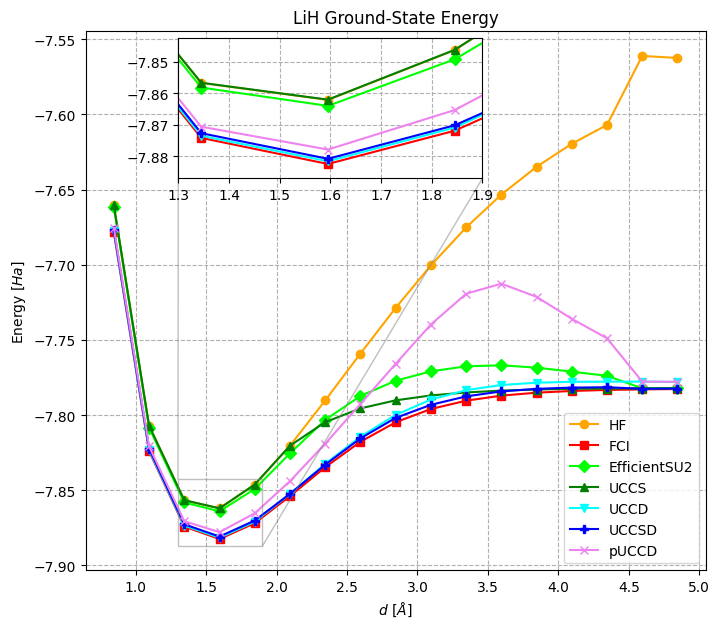

In [81]:
# Zoom sul minimo
fig, ax = plt.subplots(figsize=[8, 7])
                       
for met, style in zip(arr_methods,arr_style):  
    plt.plot(arr_distance, arr_ground_energy[met], label=met, color=style[0], marker=style[1])

plt.title("LiH Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()

# Aggiungi un inset con zoom
# [x0, y0, width, height] specifica la posizione e dimensione del riquadro
ax_inset = plt.axes([.241, .67, .38, .2]) 


# Grafico dentro il grafico (zoom)
'''
for met in method:  
    ax_inset.plot(arr_distance, arr_ground_energy[met])
'''

# Imposta i limiti di zoom
ax_inset.axis(xmin=1.3,xmax=1.9)
ax_inset.axis(ymin=-7.887,ymax=-7.8425)

for met, style in zip(arr_methods,arr_style):  
    ax_inset.plot(arr_distance, arr_ground_energy[met], label=met, color=style[0], marker=style[1])


# Aggiungi griglia nel grafico piccolo
ax_inset.grid(linestyle='--')
ax.indicate_inset_zoom(ax_inset)

plt.show()

## GRAFICI CONVERGENZA 

Plot del processo di ottimizzazione alla distanza di legame 1.6

Tutti insieme non si capisce niente

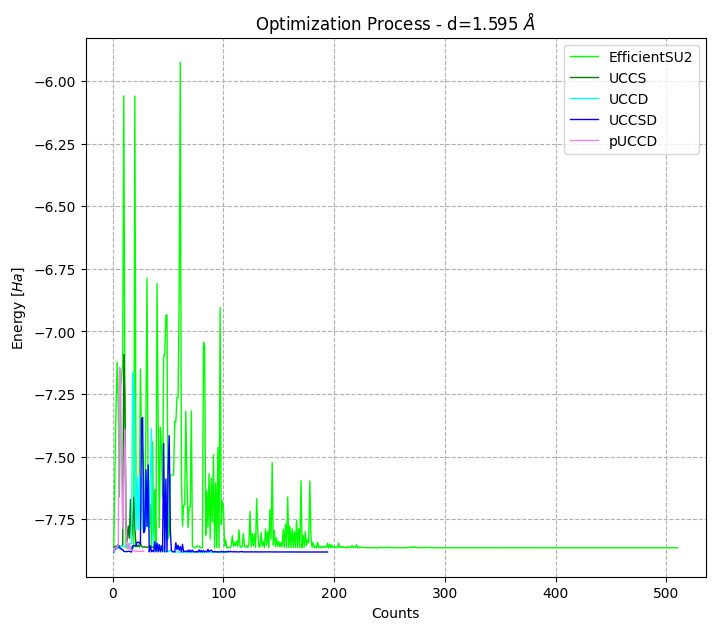

In [82]:
# 1.6 è il quarto elemento di arr_distance (indice 3)
fig, ax = plt.subplots(figsize=[8, 7])
# probabilmente in python c'è un modo più intelligente
for met, style in zip(arr_methods, arr_style):  
    if met in ['HF', 'FCI']:
        continue
    else:
        counts = arr_intermediate[met][3][0]
        values = arr_intermediate[met][3][1]
        ax.plot(counts, values, label=met, color=style[0], linewidth=1.)#, marker=style[1])

# Aggiungi etichette e titolo
ax.set_title(r"Optimization Process - d=1.595 $\AA$")
ax.set_xlabel(r"Counts")
ax.set_ylabel(r"Energy $[Ha]$")
ax.grid(linestyle='--')
ax.legend()

plt.show()

<>:13: SyntaxWarning: invalid escape sequence '\A'
<>:13: SyntaxWarning: invalid escape sequence '\A'
/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_21351/1981658719.py:13: SyntaxWarning: invalid escape sequence '\A'
  plt.title(r"Optimization Process - " + met + ' d=1.595 $\AA$')


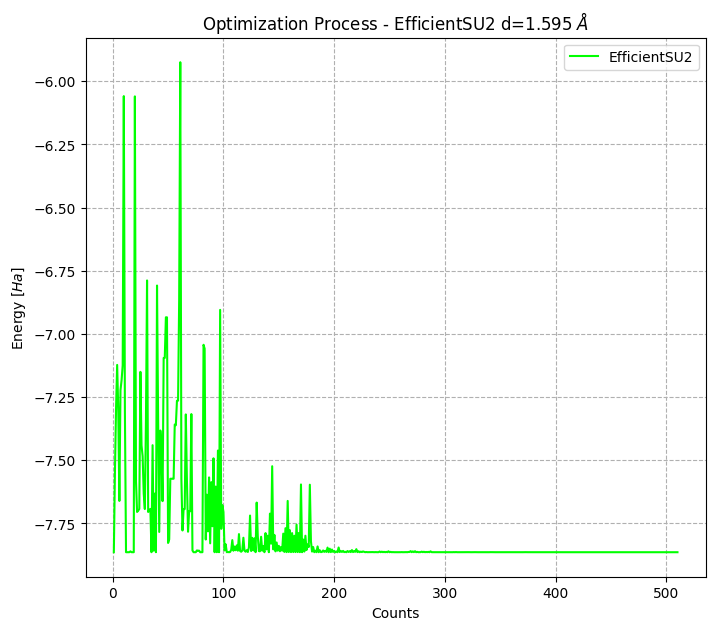

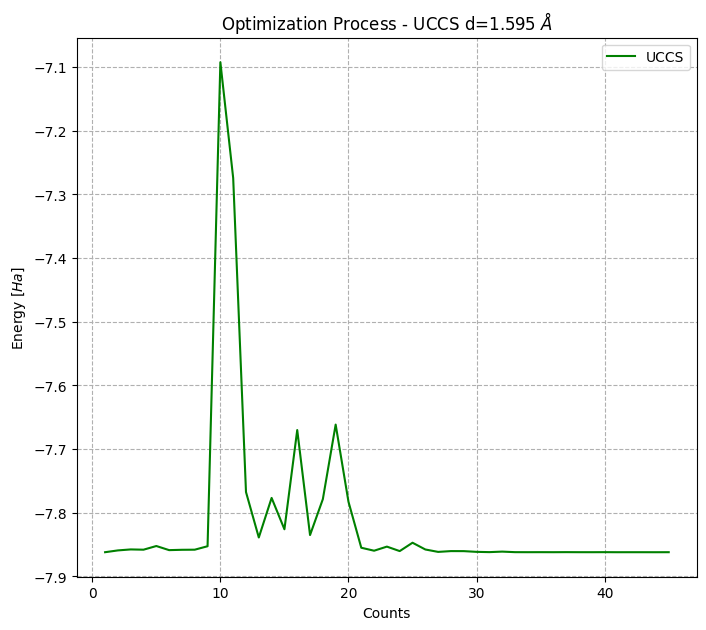

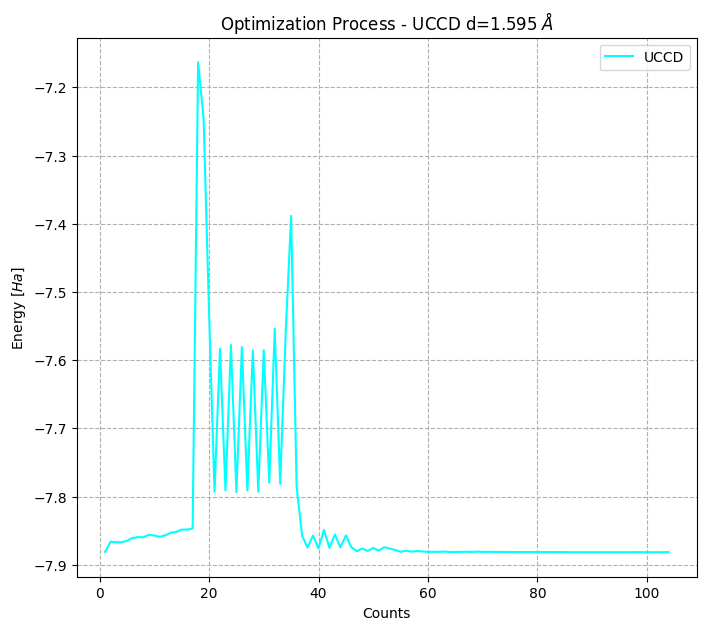

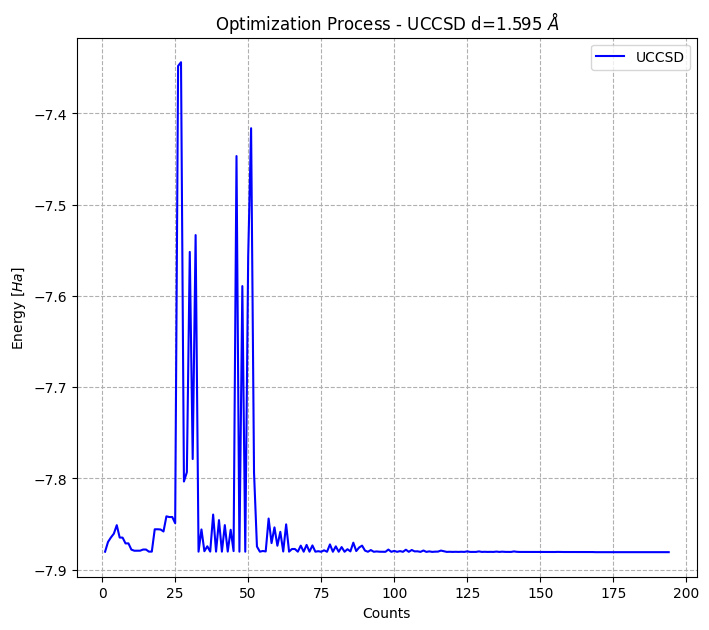

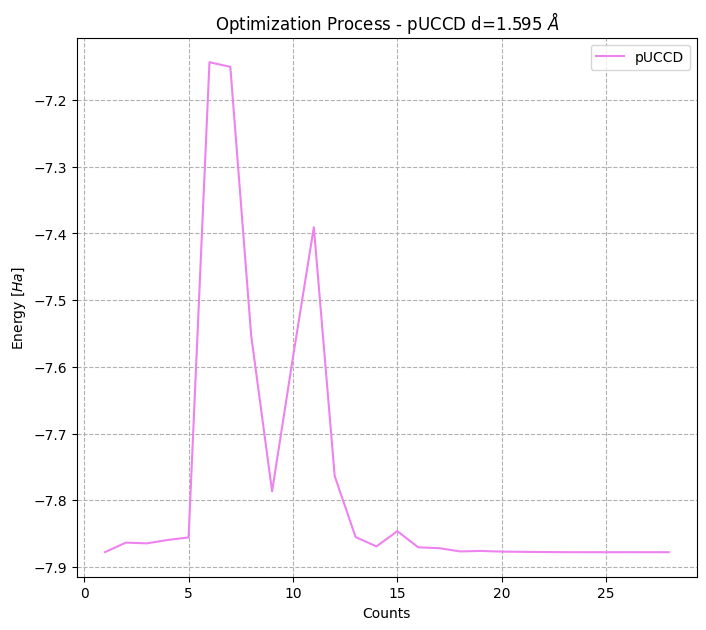

In [83]:
# 1.6 è il quarto elemento di arr_distance (indice 3)

for met, style in zip(arr_methods, arr_style):  
    if met in ['HF', 'FCI']:
        continue
    else:
        plt.figure(figsize=[8, 7]) 
        counts = arr_intermediate[met][3][0]
        values = arr_intermediate[met][3][1]
        plt.plot(counts, values, label=met, color=style[0])#, marker=style[1]) # niente marker che crea confusione

    # Aggiungi etichette e titolo
    plt.title(r"Optimization Process - " + met + ' d=1.595 $\AA$')
    plt.xlabel(r"Counts")
    plt.ylabel(r"Energy $[Ha]$")
    plt.grid(linestyle='--')
    plt.legend()

    plt.show()

# Energie ground e errori

In [84]:
metodi_ucc = ['EfficientSU2', 'UCCS', 'UCCD', 'UCCSD', 'pUCCD']
for met in metodi_ucc:
    print(met + ':\n', arr_intermediate[met][-1][2]) # array std

EfficientSU2:
 [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, 

In [85]:
print('Riferimento FCI:')
print('Ground:', arr_ground_energy['FCI'][3])
print('Dissociazione:', arr_ground_energy['FCI'][-1])

Riferimento FCI:
Ground: -7.882401932290221
Dissociazione: -7.782662470038797


In [86]:
# come errore provo a prendere std dell'ultimo valore calcolato

print('GROUND ENERGY')
for met in metodi_ucc:
    print(met + ': ', arr_ground_energy[met][3], '±', arr_intermediate[met][3][2][-1]) # array std
    
print('DISSOCIAZIONE')
for met in metodi_ucc:
    print(met + ': ', arr_ground_energy[met][-1], '±', arr_intermediate[met][-1][2][-1]) # array std

GROUND ENERGY
EfficientSU2:  -7.863937930458836 ± {}
UCCS:  -7.86195929897971 ± {}
UCCD:  -7.881540231589657 ± {}
UCCSD:  -7.880763409879368 ± {}
pUCCD:  -7.877818390982521 ± {}
DISSOCIAZIONE
EfficientSU2:  -7.781971829138271 ± {}
UCCS:  -7.782132174905694 ± {}
UCCD:  -7.777979143696523 ± {}
UCCSD:  -7.782308633029965 ± {}
pUCCD:  -7.777817957141877 ± {}


# Zoom su dissociazione

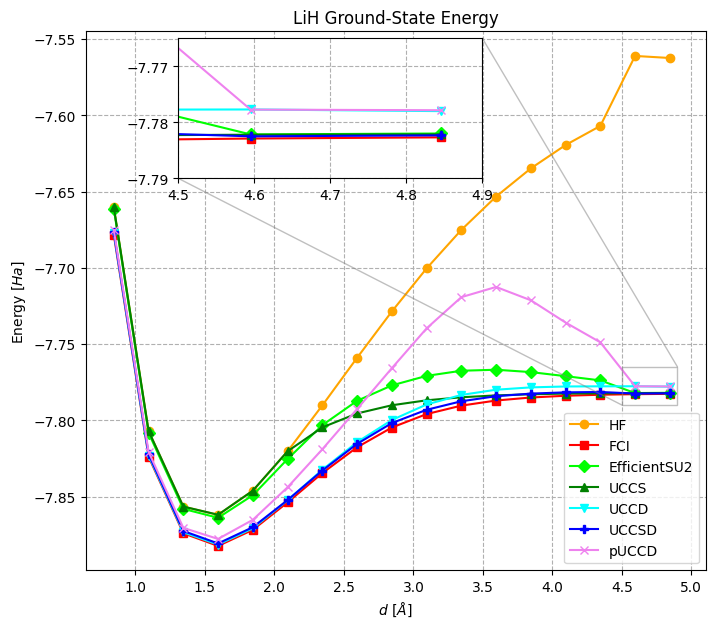

In [88]:
# Zoom a infinito
fig, ax = plt.subplots(figsize=[8, 7])
                       
for met, style in zip(arr_methods,arr_style):  
    plt.plot(arr_distance, arr_ground_energy[met], label=met, color=style[0], marker=style[1])

plt.title("LiH Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()

# Aggiungi un inset con zoom
# [x0, y0, width, height] specifica la posizione e dimensione del riquadro
ax_inset = plt.axes([.241, .67, .38, .2]) 


# Grafico dentro il grafico (zoom)
'''
for met in method:  
    ax_inset.plot(arr_distance, arr_ground_energy[met])
'''

# Imposta i limiti di zoom
ax_inset.axis(xmin=4.5,xmax=4.9)
ax_inset.axis(ymin=-7.79,ymax=-7.765)

for met, style in zip(arr_methods,arr_style):  
    ax_inset.plot(arr_distance, arr_ground_energy[met], label=met, color=style[0], marker=style[1])


# Aggiungi griglia nel grafico piccolo
ax_inset.grid(linestyle='--')
ax.indicate_inset_zoom(ax_inset)

plt.show()